# Neural Style Transfer

This lab will demonstrate neural style transfer using a pretrained VGG19 model as the feature extractor. You will see how to get outputs from specific layers of the model to compute the style and content loss, then use that to update the content image. The techniques you use here will be very useful in this week's programming assignment. You will also revisit this lab after Lesson 2 of this week when you learn about the total variation loss.

https://keras.io/api/applications/vgg/#vgg19-function

https://github.com/sasidhar-programmer/Tensorflow_Advance_Techniques/blob/main/4-Generative-deeplearning-with-tensorflow/week-1/C4_W1_Lab_1_Neural_Style_Transfer.ipynb

In [11]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import keras.backend as K
from imageio import mimsave

from IPython.display import display as display_fn
from IPython.display import Image, clear_output

In [12]:
a = tf.constant([[1,2,3], [4,5,6]])
max(tf.shape(a))
tf.newaxis
display(1)

1

In [9]:
def tensor_to_image(tensor):
    '''converts a tensor to an image'''
    tensor_shape = tf.shape(tensor)
    num_dims = tf.shape(tensor_shape) # number of nested arrays, ie len of tensor_shape
    if num_dims > 3:
        assert tensor_shape[0] == 1 # that we have a batch of one elem
        tensor = tensor[0]
    return tf.keras.preprocessing.image.array_to_img(tensor)

def load_img(img_path):
    '''loads an image from path and scales it to 512'''
    max_dim = 512
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.shape(img)[:-1] # exclude the num_channels 
    shape = tf.cast(shape, tf.float32)
    longest_dim = max(shape) 
    scale = max_dim / longest_dim # normalization scale
    new_shape = tf.cast(shape*scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :] # this is like expand_dims(axis=0)
    img = tf.image.convert_image_dtype(img, tf.uint8)

    return img

def load_content_and_style_images(content_path, style_path):
    content_img = load_img(content_path)
    style_image = load_img(style_path)
    return content_img, style_image


In [13]:
def imshow(image, title=None):
  '''displays an image with a corresponding title'''
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)
    
    
def show_images_with_objects(images, titles=[]):
  '''displays a row of images with corresponding titles'''
  if len(images) != len(titles):
    return

  plt.figure(figsize=(20, 12))
  for idx, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1, len(images), idx + 1)
    plt.xticks([])
    plt.yticks([])
    imshow(image, title)


def display_gif(gif_path):
  '''displays the generated images as an animated gif'''
  with open(gif_path,'rb') as f:
    display_fn(Image(data=f.read(), format='png'))


def create_gif(gif_path, images):
  '''creates animation of generated images'''
  mimsave(gif_path, images, fps=1)
  
  return gif_path


def clip_image_values(image, min_value=0.0, max_value=255.0):
  '''clips the image pixel values by the given min and max'''
  return tf.clip_by_value(image, clip_value_min=min_value, clip_value_max=max_value)


def preprocess_image(image):
  '''centers the pixel values of a given image to use with VGG-19'''
  image = tf.cast(image, dtype=tf.float32)
  image = tf.keras.applications.vgg19.preprocess_input(image)

  return image

In [14]:


IMAGE_DIR = 'images'

# create directory
!mkdir {IMAGE_DIR}

# download images to the directory you just created
!wget -q -O ./images/cafe.jpg https://cdn.pixabay.com/photo/2018/07/14/15/27/cafe-3537801_1280.jpg
!wget -q -O ./images/swan.jpg https://cdn.pixabay.com/photo/2017/02/28/23/00/swan-2107052_1280.jpg
!wget -q -O ./images/tnj.jpg https://i.dawn.com/large/2019/10/5db6a03a4c7e3.jpg
!wget -q -O ./images/rudolph.jpg https://cdn.pixabay.com/photo/2015/09/22/12/21/rudolph-951494_1280.jpg
!wget -q -O ./images/dynamite.jpg https://cdn.pixabay.com/photo/2015/10/13/02/59/animals-985500_1280.jpg
!wget -q -O ./images/painting.jpg https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg

print("image files you can choose from: ")
!ls images


image files you can choose from: 
cafe.jpg  dynamite.jpg	painting.jpg  rudolph.jpg  swan.jpg  tnj.jpg


In [15]:


# set default images
content_path = f'{IMAGE_DIR}/swan.jpg'
style_path = f'{IMAGE_DIR}/painting.jpg'



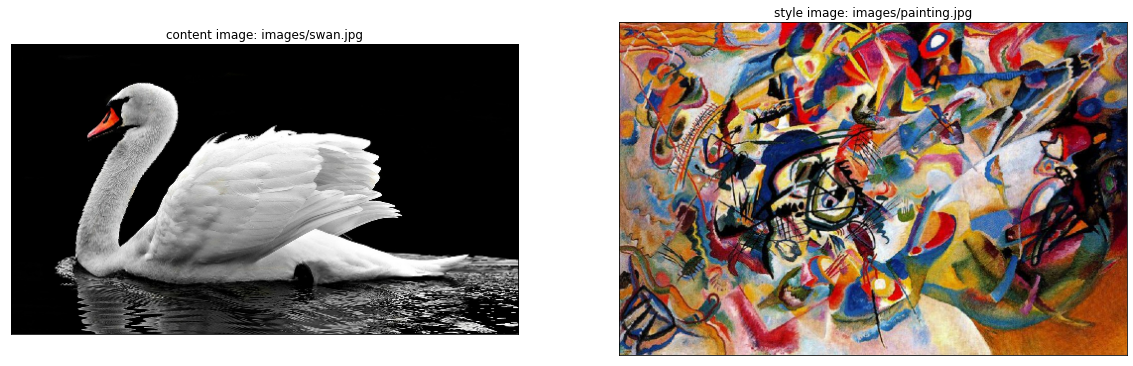

In [17]:
# display the content and style image
content_image, style_image = load_content_and_style_images(content_path, style_path)
show_images_with_objects([content_image, style_image], 
                         titles=[f'content image: {content_path}',
                                 f'style image: {style_path}'])

# Build the model

### As mentioned, you will be using the VGG-19 model as the feature extractor. You will feed in the style and content image and depending on the computed losses, a new image will be generated which has elements of both the content and style image. You can download a temporary copy of the model just for inspecting the layers that are available for you to use.

![](../screenshots/2022-03-07-06-38-40.png)

In [18]:

# clear session to make layer naming consistent when re-running this cell
K.clear_session()

# download the vgg19 model and inspect the layers
tmp_vgg = tf.keras.applications.vgg19.VGG19()
tmp_vgg.summary()

# delete temporary variable
del tmp_vgg


574726144/574710816 [==============================] - 65s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

In [19]:

# Choose intermediate layers from the network to extract the style and content of the image:

#     For the style layers, you will use the first layer of each convolutional block.

#     For the content layer, you will use the second convolutional layer of the last convolutional block (just one layer)

# We choose lower blocks for style to capture low-level features of the style like the colors.
# and we choose last block conv layer for the content image to capture high level features, like the head-shape of the swan

# style layers of interest
style_layers = ['block1_conv1', 
                'block2_conv1', 
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'] 

# choose the content layer and put in a list
content_layers = ['block5_conv2'] 

# combine the two lists (put the style layers before the content layers)
output_layers = style_layers + content_layers 

# declare auxiliary variables holding the number of style and content layers
NUM_CONTENT_LAYERS = len(content_layers)
NUM_STYLE_LAYERS = len(style_layers)

In [20]:
def vgg_model(layer_names):
  """ Creates a vgg model that outputs the style and content layer activations.
  
  Args:
    layer_names: a list of strings, representing the names of the desired content and style layers
    
  Returns:
    A model that takes the regular vgg19 input and outputs just the content and style layers.
  
  """

  # load the the pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')

  # freeze the weights of the model's layers (make them not trainable)
  vgg.trainable = False
  
  # create a list of layer objects that are specified by layer_names
  outputs = [vgg.get_layer(name).output for name in layer_names]

  # create the model that outputs content and style layers only
  model = tf.keras.Model(inputs=vgg.input, outputs=outputs)

  return model


In [21]:
# clear session to make layer naming consistent if re-running the cell
K.clear_session()

# create a vgg-19 model
vgg = vgg_model(output_layers)
vgg.summary()


80150528/80134624 [==============================] - 9s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

# Define Loss functions
1. style loss
2. content loss
3. the combination of the two
   
## Style loss
style loss is the average of the squared differences between the features and the targets


$avg(\quad (features-targets)^2 \quad)$


<br>

## Content loss
content loss is the sum of the squared error between the features and the targets, then multiplied by the scaling factor 0.5

$$

0.5 * \Sigma \quad (features - targets)^2

$$


### Note that loss is a scaler value, it's not a vector

In [22]:
def get_style_loss(features, targets):
  """Expects two images of dimension h, w, c
  
  Args:
    features: tensor with shape: (height, width, channels)
    targets: tensor with shape: (height, width, channels)

  Returns:
    style loss (scalar)
  """
  # get the average of the squared errors
  style_loss = tf.reduce_mean(tf.square(features - targets))
    
  return style_loss

def get_content_loss(features, targets):
  """Expects two images of dimension h, w, c
  
  Args:
    features: tensor with shape: (height, width, channels)
    targets: tensor with shape: (height, width, channels)
  
  Returns:
    content loss (scalar)
  """
  # get the sum of the squared error multiplied by a scaling factor
  content_loss = 0.5 * tf.reduce_sum(tf.square(features - targets))
    
  return content_loss


# Gram matrix

Calculate the gram matrix

Use `tf.linalg.einsum` to calculate the gram matrix for an input tensor. We can use regular matrix operations but using einstein notation is more concise (a bit harder to read tho)

* In addition, calculate the scaling factor `num_locations` and divide the gram matrix calculation by num_locations.


`num_locations = height * width`

In [23]:
def gram_matrix(input_tensor):
  """ Calculates the gram matrix and divides by the number of locations
  Args:
    input_tensor: tensor of shape (batch, height, width, channels)
    
  Returns:
    scaled_gram: gram matrix divided by the number of locations
  """

  # calculate the gram matrix of the input tensor
  gram = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor) 

  # get the height and width of the input tensor
  input_shape = tf.shape(input_tensor) 
  height = input_shape[1] 
  width = input_shape[2] 

  # get the number of locations (height times width), and cast it as a tf.float32
  num_locations = tf.cast(height * width, tf.float32)

  # scale the gram matrix by dividing by the number of locations
  scaled_gram = gram / num_locations
    
  return scaled_gram


### Get the style image features

Given the style image as input, you'll get the style features of the custom VGG model that you just created using vgg_model().

to get style features from the outputs, just get the style feature layers and not the content feature layer.

In [24]:

tmp_layer_list = [layer.output for layer in vgg.layers]
tmp_layer_list


[<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv2')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_pool')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv2')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_pool')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv2')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv3')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (cr

In [25]:
# For each style layer, calculate the gram matrix.
#  Store these results in a list and return it.
def get_style_image_features(image):  
  """ Get the style image features
  
  Args:
    image: an input image
    
  Returns:
    gram_style_features: the style features as gram matrices
  """
  # preprocess the image using the given preprocessing function
  preprocessed_style_image = preprocess_image(image) 

  # get the outputs from the custom vgg model that you created using vgg_model()
  outputs = vgg(preprocessed_style_image) 

  # Get just the style feature layers (exclude the content layer)
  style_outputs = outputs[:NUM_STYLE_LAYERS] 

  # for each style layer, calculate the gram matrix for that layer and store these results in a list
  gram_style_features = [gram_matrix(style_layer) for style_layer in style_outputs] 

  return gram_style_features

### Get content image features
no need to get gram matrix for these features

In [26]:
def get_content_image_features(image):
  """ Get the content image features
  
  Args:
    image: an input image
    
  Returns:
    content_outputs: the content features of the image
  """
  # preprocess the image
  preprocessed_content_image = preprocess_image(image)
    
  # get the outputs from the vgg model
  outputs = vgg(preprocessed_content_image) 

  # get the content layers of the outputs
  content_outputs = outputs[NUM_STYLE_LAYERS:]

  # return the content layer outputs of the content image
  return content_outputs

### Calculate total loss

$$
L_{total} = \beta L_{style} + \alpha L_{content}
$$

where beta and alpha are scaler weights

In [27]:
def get_style_content_loss(style_targets, style_outputs, content_targets, 
                           content_outputs, style_weight, content_weight):
    """ Combine the style and content loss

    Args:
    style_targets: style features of the style image
    style_outputs: style features of the generated image
    content_targets: content features of the content image
    content_outputs: content features of the generated image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss

    Returns:
    total_loss: the combined style and content loss

    """
    # we use add_n vs add https://stackoverflow.com/questions/50705859/python-sum-on-array-of-tensors-vs-tf-add-n/50706126

    # sum of the style losses
    style_loss = tf.add_n([ get_style_loss(style_output, style_target)
                            for style_output, style_target in zip(style_outputs, style_targets)])

    # Sum up the content losses
    content_loss = tf.add_n([get_content_loss(content_output, content_target)
                            for content_output, content_target in zip(content_outputs, content_targets)])

    # scale the style loss by multiplying by the style weight and dividing by the number of style layers
    style_loss = style_loss * style_weight / NUM_STYLE_LAYERS 

    # scale the content loss by multiplying by the content weight and dividing by the number of content layers
    content_loss = content_loss * content_weight / NUM_CONTENT_LAYERS 

    # sum up the style and content losses
    total_loss = style_loss + content_loss 

    return total_loss


Generate the Stylized Image

You will now define helper functions to generate the new image given the total loss.
Calculate gradients

First is the function to calculate the gradients. The values here will be used to update the generated image to have more of the style and content features.

Note: If you are still in Lesson 1, please disregard the var_weight parameter. That will be defined and discussed in Lesson 2.
